In [10]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas -q

In [25]:
import os
import glob
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import mediapipe as mp
from typing import List, Optional, Tuple, Union

In [78]:
TRAIN_PATH = "/kaggle/input/american-sign-language/ASL_Dataset/Train"
TEST_PATH = "/kaggle/input/american-sign-language/ASL_Dataset/Test"

In [79]:
labels = os.listdir(TRAIN_PATH)
labels = sorted(labels)
labels

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/american-sign-language/ASL_Dataset/Train'

In [65]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
86995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


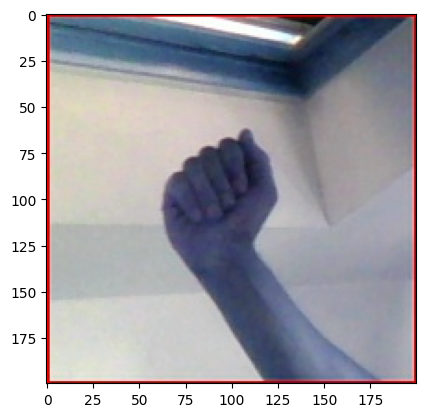

In [66]:
plt.imshow(cv2.imread(metadata['image_path'][0]))

In [72]:
class MediaPipePreprocessor:
    def __init__(self, 
                 detection_confidence: float = 0.2, 
                 tracking_confidence: float = 0.2,
                 static_image_mode: bool = True):
        # Thiết lập các giải pháp MediaPipe
        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        
        # Cấu hình hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=static_image_mode,
            max_num_hands=1,
            min_detection_confidence=detection_confidence
        )


    def load_image(self, 
                   image_path: Union[str, np.ndarray], 
                   resize: Optional[Tuple[int, int]] = None) -> np.ndarray:
        # Nếu là đường dẫn, đọc ảnh
        if isinstance(image_path, str):
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Không tìm thấy file: {image_path}")
            image = cv2.imread(image_path)
        else:
            image = image_path
        
        # Kiểm tra ảnh
        if image is None:
            raise ValueError("Không thể đọc hình ảnh")
        
        # Resize nếu được yêu cầu
        if resize:
            image = cv2.resize(image, resize, interpolation=cv2.INTER_AREA)
        
        return image

    def convert_to_rgb(self, image: np.ndarray) -> np.ndarray:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def extract_hand_landmarks(self, 
                                image: np.ndarray, 
                                visualize: bool = False) -> Optional[List[List[float]]]:
        # Chuyển sang RGB
        # image_rgb = self.convert_to_rgb(image)
        # image_rgb=cv2.flip(image,1)
        # Phát hiện bàn tay
        results = self.hands.process(image)
        
        # Nếu không phát hiện bàn tay
        if not results.multi_hand_landmarks:
            return None
        
        # Danh sách lưu trữ landmarks
        hand_landmarks_list = []
        
        # Vẽ landmarks nếu được yêu cầu
        for hand_landmarks in results.multi_hand_landmarks:
            # Trích xuất tọa độ
            landmarks = [[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]
            hand_landmarks_list.append(landmarks)
            
            if visualize:
                self.mp_drawing.draw_landmarks(
                    image, 
                    hand_landmarks, 
                    self.mp_hands.HAND_CONNECTIONS
                )
        
        return hand_landmarks_list

    def normalize_landmarks(self, landmarks: List[List[float]]) -> List[List[float]]:
        # Chuyển sang numpy để dễ tính toán
        np_landmarks = np.array(landmarks)
        
        # Tính toán giá trị trung bình và độ lệch chuẩn
        normalized_landmarks = (np_landmarks - np.mean(np_landmarks, axis=0)) / np.std(np_landmarks, axis=0)
        
        return normalized_landmarks.tolist()

    def augment_landmarks(self, 
                           landmarks: List[List[float]], 
                           noise_level: float = 0.01) -> List[List[float]]:
        # Chuyển sang numpy để dễ tính toán
        np_landmarks = np.array(landmarks)
        
        # Thêm nhiễu Gaussian
        noise = np.random.normal(0, noise_level, np_landmarks.shape)
        augmented_landmarks = np_landmarks + noise
        
        return augmented_landmarks.tolist()
    def plot_hand_landmarks(self, 
                        landmarks: List[List[float]], 
                        title: str = 'Hand Landmarks',
                        save_path: Optional[str] = None):
        # Chuyển landmarks thành numpy array
        landmarks_array = np.array(landmarks)
        
        # Tạo figure và axis
        plt.figure(figsize=(10, 10))
        
        # Vẽ các điểm landmark
        plt.scatter(
            landmarks_array[:, 0], 
            landmarks_array[:, 1], 
            c=range(len(landmarks_array)), 
            cmap='viridis', 
            s=100
        )
        
        # Nối các điểm landmark theo thứ tự
        for i in range(len(landmarks_array) - 1):
            plt.plot(
                [landmarks_array[i, 0], landmarks_array[i+1, 0]],
                [landmarks_array[i, 1], landmarks_array[i+1, 1]], 
                color='red', 
                linestyle='--', 
                alpha=0.5
            )
        
        # Đánh số thứ tự các điểm
        for i, (x, y) in enumerate(landmarks_array[:, :2]):
            plt.annotate(str(i), (x, y), xytext=(5, 5), 
                         textcoords='offset points', 
                         fontsize=8)
        
        # Thiết lập tiêu đề và nhãn
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        
        # Điều chỉnh trục để các điểm không bị méo
        plt.axis('equal')
        
        # Đảo ngược trục y để phù hợp với hệ tọa độ hình ảnh
        plt.gca().invert_yaxis()
        
        # Lưu hình nếu có đường dẫn
        if save_path:
            plt.savefig(save_path)
        
        # Hiển thị biểu đồ
        plt.show()

In [73]:
preprocessor = MediaPipePreprocessor()
image_path = metadata['image_path'][2]
image = preprocessor.load_image(image_path)

hand_landmarks = preprocessor.extract_hand_landmarks(image)
print(hand_landmarks)
if hand_landmarks:
    first_hand_landmarks = hand_landmarks[0]
    
    preprocessor.plot_hand_landmarks(
        first_hand_landmarks, 
        title='Hand Landmarks Visualization',
    )

None


W0000 00:00:1733392224.029480     642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733392224.063970     642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
